In [4]:
# importing whatever we might need
import csv
import cairo
from cairosvg import svg2png

from PIL import Image
import PIL
import png
import numpy as np
import random

import pandas as pd

import scipy.io as spio
import scipy.stats as stats
import matplotlib.pyplot as plt



### Yield SVGs from our CSV Data

In [39]:
# This should be able to read a csv file and output some text that can be read as html and rendered online
# for info on SVG notation, see:
# https://developer.mozilla.org/en-US/docs/Web/SVG/Tutorial/Paths

# super janky way of getting the stroke info into an html object that renders SVG files (gonna sandwich around it)
html_svg_obj_begin = """
<svg width="300px" height="300px" viewBox="0 0 300 300">
    <g class="sketch">
"""

html_svg_stroke_begin = """ <path fill="none" stroke="#000000" stroke-width="8" stroke-linecap="round" stroke-linejoin="round" d=" """
html_svg_stroke_end = """ " /> """

html_svg_obj_end = """
    </g>
</svg>
"""

def get_SVG(filename,show = False):
    with open(filename, newline='') as csvfile:
        file = csv.reader(csvfile)
        cur_obj_ID = "throw_away"
        cur_trial = 'none'
        cur_obj_strokes = ""
        all_object_SVGs = {}
        for row in file:
            stroke_info = ""
            whole_row = ""
            for element in row:
                whole_row += str(element)
                whole_row += ' '

            in_stroke = 0
            obj_ID = ""
            for char in whole_row:
                if in_stroke == 0:
                    obj_ID += char
                if in_stroke == 1:
                    stroke_info += char
                if char == 'M':            # super janky, perhaps this is not true of all data
                    in_stroke = 1
                    stroke_info += char

            # cleaning obj_ID so that it's just the object subordinate, i.e. deer_6
            obj_ID_list = obj_ID.split()
            obj_ID = obj_ID_list[-2]
            trial_num = obj_ID_list[-3]

            # getting rid of the last few columns, which are also not stroke info
            stroke_info_list = stroke_info.split()
            stroke_info_list = stroke_info_list[:-7]
            stroke_info = ""
            for thing in stroke_info_list:
                stroke_info += str(thing) + ' '
            whole_stroke = html_svg_stroke_begin + stroke_info + html_svg_stroke_end


            # the following code had two problems:
            # 1) if the same stim comes up twice in a row (at the split between windows of 24)
            # 2) it never actually records the last object
            # So change it please
            # if obj_ID != cur_obj_ID:
            if trial_num != cur_trial: # changing this condition should take care of concern (1) above
                cur_obj_svg = html_svg_obj_begin + cur_obj_strokes + html_svg_obj_end
                all_object_SVGs[cur_obj_ID] = cur_obj_svg
                cur_obj_strokes = whole_stroke
                cur_obj_ID = obj_ID
                cur_trial = trial_num

            # elif obj_ID == cur_obj_ID:
            elif trial_num == cur_trial:
                cur_obj_strokes += '\n' + whole_stroke
        
        # adding this trivial one at the end takes care of concern (2) above
        cur_obj_svg = html_svg_obj_begin + cur_obj_strokes + html_svg_obj_end
        all_object_SVGs[cur_obj_ID] = cur_obj_svg
        cur_obj_strokes = whole_stroke
        cur_obj_ID = obj_ID
    
    if show == True:
        for key in all_object_SVGs.keys():
            print(key)
            print(all_object_SVGs[key],'\n\n')
    
    del all_object_SVGs["throw_away"]
    del all_object_SVGs["endStrokeTime"]
    
    return all_object_SVGs

games = []
contents = ! ls
for file in contents:
    if file[-3:] == 'csv':
        game_results = get_SVG(file,show = False)
        games.append(game_results)

sample_dict = games[0]
        

In [40]:
# define the dataframe that will be our basic unit of storing data
c_vals = [None,None,None,None,None,None,None,None]  # for 8 cardinalities
d = {'Deer': c_vals, 'Owls': c_vals, 'Bears': c_vals} # for these three animals
basic_df = pd.DataFrame(d)# ,dtype=np.float) # default is integer

# example
instance_df = basic_df.copy() # don't want to retro-overwrite onto our template
instance_df['Bears'][0] = 2 # this is how you modify a specific element

print(basic_df)




   Deer  Owls Bears
0  None  None  None
1  None  None  None
2  None  None  None
3  None  None  None
4  None  None  None
5  None  None  None
6  None  None  None
7  None  None  None


### Analysis 1: Measure Surface Area of Tokens

<BarContainer object of 3 artists>

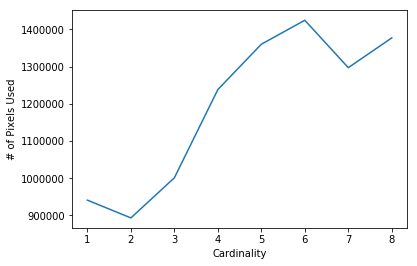

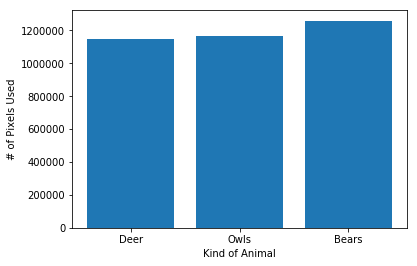

In [47]:
# Write function to analyse how much surface area was filled (maybe better do ink used?); must do for many images
def measure_SA(imlist):
    data = basic_df.copy()
    
    for item in imlist:
        # need to convert the html SVG format into png
        svg2png(bytestring=imlist[item],write_to='temp.png')
        temp_im = np.array(Image.open('temp.png'))
        animal = item[0:-2]
        columns = {'b':'Bears','d':'Deer','o':'Owls'}
        col_name = columns[animal[0]]
        
        cardinality = float(item[-1])
                
        if type(data[col_name][cardinality-1]) == np.float64:
            print("UH OH YOU JUST TRIED TO OVERWRITE A DATAPOINT")
            # work in an actual eventuality for when this happens. Need a new dimension in the df prolly
        else:
            data[col_name][cardinality-1] = np.float64(np.sum(temp_im) ) # / cardinality
            
    return data

for game in games:
    # do statistics on the amount of pixels per cardinality by animal, etc, using this dataframe
    measure_SA(game)
    
# try_me = measure_SA(sample_dict)
# print(np.array(try_me))


# First plot total pixels over cardinality
points = measure_SA(sample_dict).mean(axis=1)
plt.figure()
plt.xlabel("Cardinality")
plt.ylabel("# of Pixels Used")
plt.plot([1,2,3,4,5,6,7,8],points)

# Then plot total pixels over type of animal
points = measure_SA(sample_dict).mean(axis=0)
plt.figure()
plt.xlabel("Kind of Animal")
plt.ylabel("# of Pixels Used")
plt.bar(['Deer','Owls','Bears'],points)



### Measure 2: Measure Intersection of Tokens with their Stimulus

<BarContainer object of 3 artists>

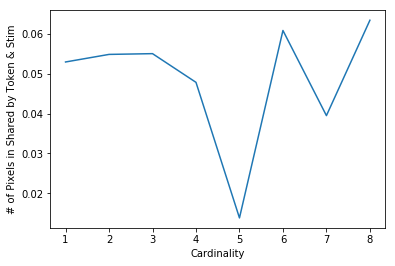

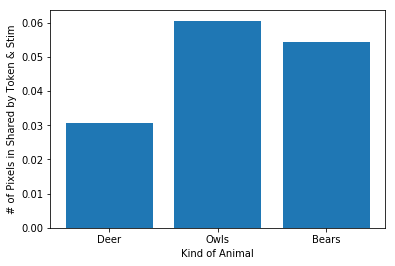

In [42]:

def norm_stim(array):
    norm_array = np.where(array == 0, array, 1)
    ones_array = np.ones(np.shape(norm_array))
    inverted_im = ones_array - norm_array
    inverted_im[:,:,3] = inverted_im[:,:,2]
    return inverted_im.astype(np.uint8)

def norm_draw(array):
    norm_array = np.where(array == 0, array, 1)
    norm_array[:,:,0] = norm_array[:,:,3]
    norm_array[:,:,1] = norm_array[:,:,3]
    norm_array[:,:,2] = norm_array[:,:,3]
    return norm_array.astype(np.uint8)

def compare_loc(imlist,display = False):
    data = basic_df.copy()
    
    for item in imlist:
        svg2png(bytestring=imlist[item],write_to='temp.png')
        
        draw_im = Image.open('temp.png')
        draw_ar = np.array(draw_im)

        # gotta write regex to have it locate the stimulus
        animals = {'b':'bear','d':'deer','o':'owl','r':'rabbit','s':'squirrel','w':'wolf'}
        stim_name = str('v0_stims/'+item[-1] + '_0_' + animals[item[0]] + '.png')
        stim_im = Image.open(stim_name).resize((300,300), resample=0)
        stim_ar = np.array(stim_im)

        product = norm_stim(stim_ar) * norm_draw(draw_ar)

        total_stim_pixels = np.sum(norm_stim(stim_ar))
        total_draw_pixels = np.sum(norm_draw(draw_ar))
        total_prod_pixels = np.sum(product)
        
        
        animal = item[0:-2]
        columns = {'b':'Bears','d':'Deer','o':'Owls'}
        col_name = columns[animal[0]]
        cardinality = float(item[-1])
        
        if type(data[col_name][cardinality-1]) == np.float64:
            print("UH OH YOU JUST TRIED TO OVERWRITE A DATAPOINT")
        else:
            data[col_name][cardinality-1] = total_prod_pixels / (total_stim_pixels+total_draw_pixels)
            # this is not a good number to use; figure out a better way to normalize the intersection
        
        
        if display == True:
            product = np.where(product == 0, product, 255)
            prod_im = Image.fromarray(draw_ar)
            prod_im.show()
        
    return data


# First plot intersection of sketch and stim over cardinality
points = compare_loc(sample_dict).mean(axis=1)
plt.figure()
plt.xlabel("Cardinality")
plt.ylabel("# of Pixels in Shared by Token & Stim")
plt.plot([1,2,3,4,5,6,7,8],points)

# Then plot intersection of sketch and stim over type of animal
points = compare_loc(sample_dict).mean(axis=0)
plt.figure()
plt.xlabel("Kind of Animal")
plt.ylabel("# of Pixels in Shared by Token & Stim")
plt.bar(['Deer','Owls','Bears'],points)


In [43]:
compare_loc(sample_dict,display=True)

,Deer,Owls,Bears
0,0.0113605,0.0533512,0.0939914
1,0,0.115938,0.0484496
2,0.000329924,0.0851539,0.0794726
3,0.0524961,0.0562867,0.0346286
4,0.0309241,0.0101241,0.000571796
5,0.0872026,0.0305787,0.0645703
6,0.0276044,0.0557582,0.0350757
7,0.0349129,0.0772729,0.0778514


In [53]:
test_array = np.ones([4,4])
test_df = pd.DataFrame(data=test_array,
                       index=[1,2,3,4],
                       columns=['A','B','C','D'])

test_df + 1



,A,B,C,D
1,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0


Text(0,0.5,'Probability')

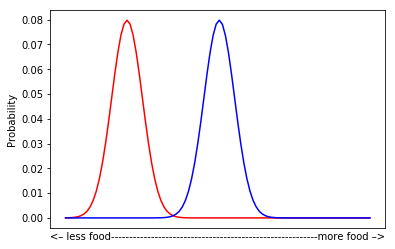

In [45]:

def doe_normaal(x,mean,s,skew=0):
    answer = (1/(s*np.sqrt(2*np.pi)))*np.e**(-((x-mean)**2)/(2*(s**2)))
    if skew == 1:
        answer = np.log(answer)
    return answer

xrange = np.arange(100)

plt.figure()
plt.plot(xrange,doe_normaal(xrange,20,5),color='r')
plt.plot(xrange,doe_normaal(xrange,50,5),color='b')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel("<– less food---------------------------------------------------------more food –>")
plt.ylabel("Probability")



In [ ]:
print('y')